## Summary

* 17th place
* Copy top agent's behavior by graph theory.
* My agent: https://www.kaggle.com/iiyamaiiyama/santa2020-s-shohei-lb11001200

#### Node
Each bandit has its state.  
Notation: [my pull, my_hit, oppnent_pull]  

e.g.  
bandit [5,3,2]: I already pulled it 5 times, rewarded 3 times, and opponent pulled it 2 times.  

There are 100 bandit with state [0,0,0] at first round of episode,  
and my agent updates them throughout episode.

#### Edge
As you see top LB agent's early game behavior, you immediatery notice that  
[1,1,0] prioritize over [0,0,0] : if hit, pull it again  
[0,0,0] prioritize over [1,0,0] : if missed, pull other untouched bandit  

This relationship can be represented as Edges.  
[1,1,0] -> [0,0,0] -> [1,0,0]

If opponent pulled same bandit twice, we should try that bandit instead of trying new one.  
[0,0,2] -> [0,0,0]

We don't want to pull bandit that opponent pulled only once, which is probably bad one.  
[0,0,0] -> [0,0,1]

then we can build a priority graph like below.

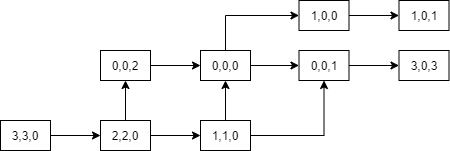

#### Topological sort
Now we got graph structure of priority, then do topological sort on this graph.  
After topological sort, we can see how good the bandit is.  
[3,3,0] is the best bandit in this graph.  

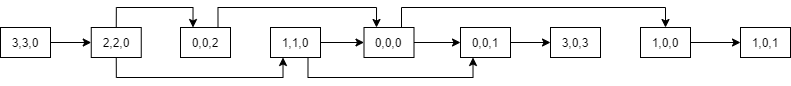

Normalize its priority to fit [0-1]
* dict[3,3,0] == 0/9 = 0
* dict[2,2,0] == 1/9 = 0.111
* ...
* dict[1,0,1] == 9/0 = 1

#### Average dict
I built a graph and dictionary from one replay.  
Then average all dictionary and get final priority_dict.  

My agent just lookup this dictionary for each bandits' state, and pick argmin.

## Check performance

In [ ]:
DEBUG=False

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import glob
import seaborn as sns

from tqdm import tqdm

In [ ]:
replay_dir = "../input/santa-replay-s-shohei/replay/"
TEAMNAME = "s_shohei"

In [ ]:
json_paths=[]
json_info_paths=[]
agent_set = set()
for cnt,path in enumerate(glob.glob(replay_dir+"*")):   
    agent=int(path.split("_")[0].split("/")[-1])  
    agent_set.add(str(agent))
    if path.count("info")!=0:
        json_info_paths.append(path)
    else:
        json_paths.append(path)
        cnt+=1
    if DEBUG and cnt>30:
        break
len(json_paths)

## Code

In [ ]:
json_paths[0:5]

In [ ]:
json_open = open(json_paths[0], 'r')
json_load = json.load(json_open)
json_load["info"]["TeamNames"]

In [ ]:
def get_df(json_load):
    left_hit=[]
    left_action=[]

    right_hit=[]
    right_action=[]

    left_last_reward=0
    right_last_reward=0

    rows_list=[]
    
    if TEAMNAME in json_load["info"]["TeamNames"][0]:
        team=0
    elif TEAMNAME in json_load["info"]["TeamNames"][1]:
        team=1
    else:
        return None

    for step in range(1,2000):
        d=dict()
        left = json_load["steps"][step][team]
        right = json_load["steps"][step][1-team]

        d["left_hit"] = left["reward"] != left_last_reward
        d["right_hit"] = right["reward"] != right_last_reward

        d["left_action"] = left["action"]
        d["right_action"] = right["action"]
        rows_list.append(d)
        
        left_last_reward = left["reward"] 
        right_last_reward = right["reward"]    
        
    return pd.DataFrame(rows_list)

In [ ]:
X_df = get_df(json_load)
X_df.shape

In [ ]:
X_df.head()

Left agent pulled bandit 14 at first round, and got no reward.

## Functions

In [ ]:
def topological_sort(all_node_list, inc_list, link):
    s=[]
    for node in all_node_list:
        if inc_list[node]==0:
            s.append(node)
    
    s.reverse()
    res=defaultdict(int)
    cnt=0
    
    while s:
        node=s.pop()
        res[node]=cnt
        cnt+=1
        
        for nxt in link[node].keys():
            if link[node][nxt]==0:
                continue
            inc_list[nxt] -= link[node][nxt]
            if inc_list[nxt]==0:
                s.append(nxt)
    return res

In [ ]:
from collections import deque

def bfs(src_node,link):
    visited=set()
    
    visited.add(src_node)
    Q = deque()
    Q.append(src_node)
    
    while Q:
        now = Q.popleft()
        for nxt in link[now].keys():
            if nxt in visited or link[now][nxt]==0:
                continue
            visited.add(nxt)
            Q.append(nxt)
    return visited

In [ ]:
# encode node [0,0,0] -> "0_0_0"
def node_num(node):
    return str(int(node[0]))+"_" + str(int(round(node[1])))+"_"+str(int(node[2]))

def add_edge(src_node_num, node_list, link, r_link, inc_list):
    src_node = node_num(node_list[src_node_num])
    adding_dst_nodes = []
    
    for i in range(100):
        dst_node = node_num(node_list[i])
        
        if link[dst_node][src_node] == 0:
            # just add this
            adding_dst_nodes.append(dst_node)
        else:
            # ignore this edge and "cancel" existing edge
            link[dst_node][src_node] -= 1
            r_link[src_node][dst_node] -= 1
            inc_list[src_node] -= 1
            
            if link[dst_node][src_node] < 0:
                raise BaseException("link must be >= 0")
            if r_link[src_node][dst_node] < 0:
                raise BaseException("r_link must be >= 0")
            if inc_list[src_node] < 0:
                raise BaseException("inc_list must be >= 0")
    
    # check parents to prevent add loop
    parents_node_set = bfs(src_node,r_link) # reverse bfs   
    
    # add new edge
    for dst_node in adding_dst_nodes:
        if dst_node in parents_node_set or src_node == dst_node:
            # Topological sort requires DAG(directed acyclic graph), so don't add edge to its parent
            continue 
            
        inc_list[dst_node] += 1
        link[src_node][dst_node] +=1
        r_link[dst_node][src_node] += 1

In [ ]:
from collections import defaultdict
import dill

def create_dict(json_path):
    json_open = open(json_path, 'r')
    json_load = json.load(json_open)

    if len(json_load["steps"]) != 2000: # invalid episode
        return [],[]

    X_df = get_df(json_load)

    if X_df is None:
        return [],[]
    
    link   = defaultdict(lambda:defaultdict(int)) # link like [2,2,0] -> [0,0,0]
    r_link = defaultdict(lambda:defaultdict(int)) # reverse link
    inc_list = defaultdict(int) # number of incoming edge for topological sort
    
    node_list = np.zeros((100,3)) # my_pull, my_hit, opp_pull

    for i in range(X_df.shape[0]):
        row = X_df.iloc[i]
        
        # update link
        add_edge(row.left_action,node_list,link,r_link,inc_list)

        # update state of node
        # my pull node
        my_pull, my_hit, opp_pull = node_list[row.left_action]
        my_hit += row.left_hit
        my_pull+=1
        node_list[row.left_action]  = my_pull, my_hit, opp_pull

        # opp pull node
        my_pull, my_hit, opp_pull = node_list[row.right_action] 
        opp_pull+=1
        node_list[row.right_action] = my_pull, my_hit, opp_pull

    all_node_list = list(link.keys())
    group = topological_sort(all_node_list, inc_list, link)
    
    return group,link

## Build graph

In [ ]:
len(json_paths)

In [ ]:
%%time
from joblib import Parallel, delayed
sub = Parallel(n_jobs=-1, verbose=10)( [delayed(create_dict)(j) for j in json_paths[0:500]] )

In [ ]:
# first replay has 2275 state
link = sub[0][1]
len(link.keys())

In [ ]:
# node state(name) example
list(link.keys())[-10:]

In [ ]:
# dictionary
d = sub[0][0]
len(d.keys())

In [ ]:
# let's see topological sort order.
# lower order means better node, not normalized yet
print(d["0_0_0"])
print(d["0_0_2"])
print(d["2_2_0"])
print(d["2_2_2"])
print(d["23_6_11"])

## Average all dictionary

In [ ]:
node_set = set()
for i in range(len(sub)):
    if len(sub[i][0])==0:
        continue
    node_list = sub[i][0].keys()
    node_set = node_set | set(node_list)

prio_dict = defaultdict(lambda: 1) # unknown node returns worst priority:1
for node in tqdm(node_set):
    prio_tmp_lis = []
    for i in range(len(sub)):
        if len(sub[i][0])==0:
            continue
        if not node in sub[i][0].keys():
            continue
        dict_len = len(sub[i][0].keys())

        p = sub[i][0][node]/dict_len # normalize
        if p!=0:
            prio_tmp_lis.append(p)

    if len(prio_tmp_lis) == 0:
        prio_dict[node]=1
    else:
        prio_dict[node] = np.mean(prio_tmp_lis) # mean of all replay's priority

In [ ]:
!mkdir -p /kaggle_simulations/agent
fname = "priority_dict.dill"
dill.dump(prio_dict, open(fname,'wb'))
!mv $fname /kaggle_simulations/agent/

In [ ]:
print(prio_dict["0_0_0"]) # untouched node
print(prio_dict["1_1_0"])
print(prio_dict["2_2_0"]) # one of the best state
print(prio_dict["3_3_0"])
print(prio_dict["4_4_0"])
print()
print(prio_dict["23_6_11"]) # bad state
print(prio_dict["100_100_100"]) # returns 1 for unknown node

In [ ]:
print(prio_dict["0_0_0"]) # untouched node
print(prio_dict["0_0_1"]) # avoid node opp_pull == 1
print(prio_dict["0_0_2"]) # must try
print(prio_dict["0_0_3"]) # must try
print(prio_dict["0_0_4"])

In [ ]:
print(prio_dict["23_6_11"])
print(prio_dict["23_7_11"])
print(prio_dict["23_8_11"])
print(prio_dict["23_9_11"])
print(prio_dict["23_10_11"])

## Visualize
You can see priority gradation.  
In this notebook, lower priority value means better node.

In [ ]:
num1=50 # my_pull
num2=50 # my_hit
arr = [[0 for _ in range(num2)] for _ in range(num1)]

for i in range(num1): # my_pull
    for j in range(num2): # my_hit
        p = prio_dict[node_num([i,j,5])] # opp_pull==5
        arr[i][j] = p

plt.figure(figsize = (10,7))
sns.heatmap(arr, annot=False,square=True,vmin=0,vmax=1,cmap="ocean")
plt.xlabel("my_hit")
plt.ylabel("my_pull")

In [ ]:
num1=50 # my_pull
num2=50 # my_hit
arr = [[0 for _ in range(num2)] for _ in range(num1)]

for i in range(num1): # my_pull
    for j in range(num2): # my_hit
        p = prio_dict[node_num([i,j,30])] # opp_pull==30
        arr[i][j] = p

plt.figure(figsize = (10,7))
sns.heatmap(arr, annot=False,square=True,vmin=0,vmax=1,cmap="ocean")
plt.xlabel("my_hit")
plt.ylabel("my_pull")

more my_hit -> lower priority (good node)  
more my_pull -> higher priority (bad node)  
more opp_pull -> higher priority  

## evaluate

In [ ]:
!pip install kaggle-environments --upgrade

Sparring partner  
https://www.kaggle.com/iehnrtnc/santa2020 

In [ ]:
%%writefile agent3.py

# https://www.kaggle.com/iehnrtnc/santa2020

import math, random

history = {
    "turn": 0,
    "cnts": [0] * 100,
    "ocnts": [0] * 100,
    "hits": [0] * 100,
    "osteps": [0] * 100,
    "la": -1,
}

def agent3(observation, configuration):
    global history

    N = 100
    p = [0.5, 0.000138, 1.24]
    step = observation["step"]
    if step == 0:
        pass
    else:
        la = history["la"]
        ola = sum(observation['lastActions']) - la
        history["osteps"][ola] = step
        if sum(history["hits"]) < observation['reward']:
            history["hits"][la] += 1 / pow(0.97, history["cnts"][la] + history["ocnts"][la])
        history["cnts"][la] += 1
        history["ocnts"][ola] += 1

    tau = p[0] / (step + 1) + p[1]
    ea = [0] * N
    hits = history["hits"]
    cnts = history["cnts"]
    ocnts = history["ocnts"]
    osteps = history["osteps"]

    tv = sorted([(-ocnts[i], osteps[i], i) for i in range(N)])
    ot = [0] * N
    for i in range(N):
        ot[tv[i][2]] = 99 - i

    for i in range(N):
        if cnts[i] == 0:
            if ocnts[i] > 1:
                ea[i] = math.exp(min(500, ot[i] / 100 * pow(0.97, ocnts[i]) / tau))
            else:
                ea[i] = math.exp(min(500, 0.99 * pow(0.97, ocnts[i]) / tau))
        else:
            w = pow(cnts[i], p[2])
            wo = ocnts[i]
            if ocnts[i] < 2:
                wo = 0
            r = hits[i] / cnts[i]
            ro = ot[i] / 100
            ea[i] = math.exp(min(500, (r * w + ro * wo) / (w + wo) * pow(0.97, cnts[i] + ocnts[i]) / tau))

    se = sum(ea)
    r = random.random() * se
    t = 0
    la = 99
    for i in range(N):
        t += ea[i]
        if t >= r:
            la = i
            break

    history["la"] = la
    return la

In [ ]:
%%writefile /kaggle_simulations/agent/main.py

import numpy as np
import dill

fname = "/kaggle_simulations/agent/priority_dict.dill"
loaded_dict = dill.load(open(fname,'rb'))

def node_name(node):
    return str(int(node[0]))+"_" + str(int(round(node[1])))+"_"+str(int(node[2]))

def get_priority(node):
    node = node_name(node)
    return loaded_dict[node]
    
node_list = np.zeros((100,3)) # my_pull, my_hit, opp_pull

total_reward = 0
my_last_act=0

def agent(observation, configuration):
    global node_list,total_reward,my_last_act
    
    if observation.step == 0:
        node_list = np.zeros((100,3))
    else:
        r = observation.reward - total_reward # 1 if my_last_act was hit
        total_reward = observation.reward
        opp_last_act = sum(observation['lastActions']) - my_last_act 
        
        # update node's state
        node_list[my_last_act][1] += r
        node_list[my_last_act][0] += 1
        
        node_list[opp_last_act][2] += 1
    
    node_score_list=[0]*100
    for i in range(100):
        # actually no need to update all bandit.
        # update my_last_act and opp_last_act is enough.
        node_score_list[i] = get_priority(node_list[i])

    my_last_act = int(np.argmin(node_score_list))

    return my_last_act

In [ ]:
from kaggle_environments import make

env = make("mab", debug=True)

output = env.run(["/kaggle_simulations/agent/main.py", "agent3.py"])
print('Left player: reward = %s, status = %s, info = %s' % (output[-1][0]['reward'], output[-1][0]['status'], output[-1][0]['info']))
print('Right player: reward = %s, status = %s, info = %s' % (output[-1][1]['reward'], output[-1][1]['status'], output[-1][1]['info']))
env.render(mode="ipython", width=500, height=500)